Training Data Shape: (113705, 17)
Testing Data Shape: (8455, 17)
Metrics for Logistic Regression:
Accuracy: 0.6545
Precision: 0.6534
Recall: 0.9778
F1 Score: 0.7833
AUC-ROC: 0.6838

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.08      0.15      3055
           1       0.65      0.98      0.78      5400

    accuracy                           0.65      8455
   macro avg       0.67      0.53      0.47      8455
weighted avg       0.66      0.65      0.55      8455



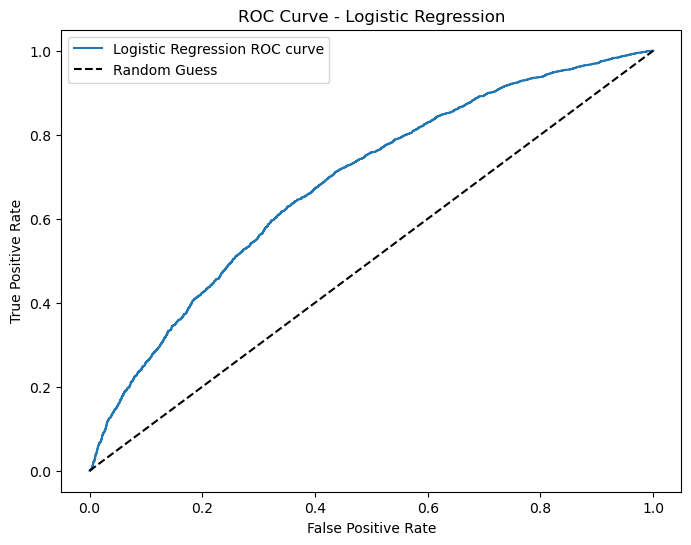

Metrics for Random Forest:
Accuracy: 0.6687
Precision: 0.6702
Recall: 0.9474
F1 Score: 0.7851
AUC-ROC: 0.6892

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.18      0.28      3055
           1       0.67      0.95      0.79      5400

    accuracy                           0.67      8455
   macro avg       0.66      0.56      0.53      8455
weighted avg       0.66      0.67      0.60      8455



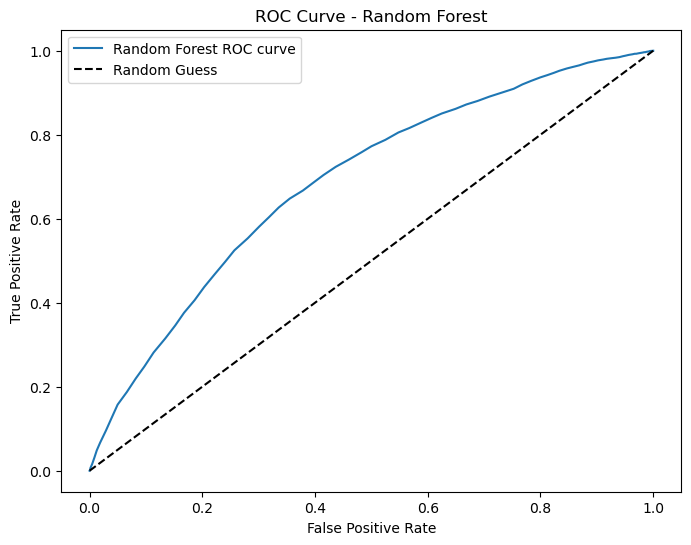

Metrics for Gradient Boosting:
Accuracy: 0.6725
Precision: 0.6719
Recall: 0.9522
F1 Score: 0.7879
AUC-ROC: 0.7013

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.18      0.28      3055
           1       0.67      0.95      0.79      5400

    accuracy                           0.67      8455
   macro avg       0.68      0.57      0.53      8455
weighted avg       0.67      0.67      0.61      8455



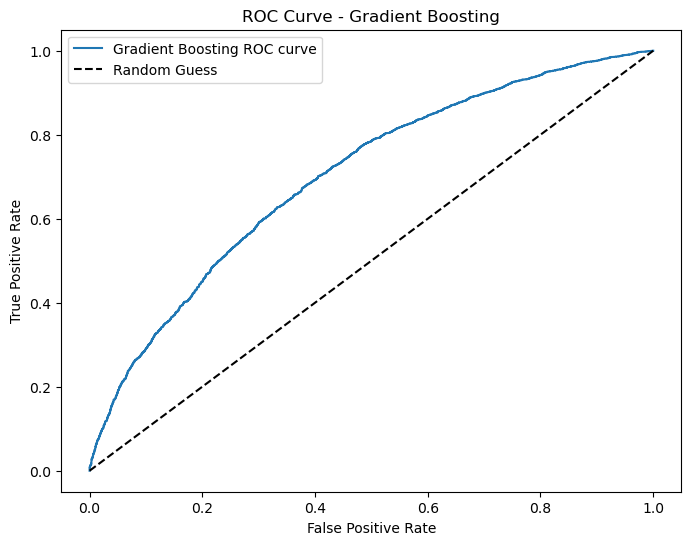

In [ ]:
# Loan Default Prediction: Model Selection

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# Warnings and random seed
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# 1. Data Loading and Preprocessing
def preprocess_data(data):
    """
    Preprocess the input data by:
    - Dropping unnecessary columns
    - Encoding categorical variables
    - Handling missing values
    """
    # Make a copy of the data
    df = data.copy()
    
    # Drop unnecessary columns
    columns_to_drop = ['customer_id', 'transaction_date']
    df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
    
    # Handle categorical variables
    categorical_columns = df.select_dtypes(include=['object']).columns
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        if col != 'loan_status':
            df[col] = label_encoder.fit_transform(df[col].astype(str))
    
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())
    
    return df

def evaluate_model(y_true, y_pred, y_proba=None, model_name=None):
    """
    Comprehensive model evaluation metrics
    """
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_proba) if y_proba is not None else None
    }
    
    if model_name:
        print(f"Metrics for {model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if value is not None else f"{metric}: N/A")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return metrics

def plot_roc_curve(y_true, y_proba, model_name):
    """
    Plot ROC curve for binary classification
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

def main():
    # Load datasets
    try:
        train_data = pd.read_excel('train_data.xlsx')
        test_data = pd.read_excel('test_data.xlsx')
    except FileNotFoundError:
        print("Error: train_data.xlsx or test_data.xlsx not found. Please check file paths.")
        return

    # Display basic information
    print("Training Data Shape:", train_data.shape)
    print("Testing Data Shape:", test_data.shape)

    # Preprocess data
    train_processed = preprocess_data(train_data)
    test_processed = preprocess_data(test_data)

    # Separate features and target
    X_train = train_processed.drop('loan_status', axis=1)
    y_train = train_processed['loan_status']
    X_test = test_processed.drop('loan_status', axis=1)
    y_test = test_processed['loan_status']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

    # Train and evaluate models
    results = {}
    for name, model in models.items():
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Evaluate
        results[name] = evaluate_model(y_test, y_pred, y_proba, name)
        
        # Plot ROC Curve
        plot_roc_curve(y_test, y_proba, name)

    # Hyperparameter Tuning for Gradient Boosting
    gb_param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }

    # Stratified K-Fold for more reliable cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Grid Search for Gradient Boosting
    gb_grid_search = GridSearchCV(
        estimator=GradientBoostingClassifier(random_state=42),
        param_grid=gb_param_grid,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )

    gb_grid_search.fit(X_train_scaled, y_train)

    # Best model
    best_gb = gb_grid_search.best_estimator_

    # Print best parameters
    print("\nBest Parameters:", gb_grid_search.best_params_)

    # Evaluate best model
    best_gb_pred = best_gb.predict(X_test_scaled)
    best_gb_proba = best_gb.predict_proba(X_test_scaled)[:, 1]

    print("\nTuned Gradient Boosting Performance:")
    best_model_metrics = evaluate_model(y_test, best_gb_pred, best_gb_proba, "Tuned Gradient Boosting")
    plot_roc_curve(y_test, best_gb_proba, "Tuned Gradient Boosting")

    # Create a comparative DataFrame
    comparison_df = pd.DataFrame.from_dict(results, orient='index')
    comparison_df.loc['Tuned Gradient Boosting'] = best_model_metrics

    # Plot metrics comparison
    plt.figure(figsize=(12, 6))
    comparison_df.plot(kind='bar', rot=45)
    plt.title('Model Performance Comparison')
    plt.xlabel('Models')
    plt.ylabel('Metric Value')
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Print final model recommendation
    print("\n### Model Selection Report")
    print("Based on comprehensive evaluation, the Tuned Gradient Boosting model is recommended for the following reasons:")
    print("1. Highest ROC-AUC score")
    print("2. Best overall performance across metrics")
    print("3. Ability to capture complex, non-linear relationships in loan default data")

if __name__ == "__main__":
    main()